# Higher Radix Adder 
The following consists of the resource estimation information from Azure Quantum Resource Estimator on the implementation of a quantum higher radix adder from https://www.nature.com/articles/s41598-023-41122-4. This is using the Craig Gidney RCA as implemented in Q#'s `Std.Arithmetic.RippleCarryCGAddLE`.

Unfortunately, Azure Quantum Resource Estimator does NOT take into account parallelization which is a key benefit to using a higher radix adder. This is evident by the following tests in which the higher radix always performs worse than not using the higher radix.

In [1]:
import qsharp
from diskcache import Cache
import re_utils
import json
import pandas as pd
import os 
import time
from matplotlib import pyplot as plt

re_utils.DEBUG = False

cache = Cache("~/quant-arith-cache/re-radix")
qsharp.init(project_root="../lib/")

@cache.memoize()
def estimate_resources_radix(op, n, radix, adder_op="Std.Arithmetic.RippleCarryCGAddLE", carry_flag=False):
    if carry_flag:
        est = qsharp.estimate(f"EstimateUtils.RunRadixCarry({n},{radix},{op},{adder_op})")
    else:
        est = qsharp.estimate(f"EstimateUtils.RunRadix({n},{radix},{op},{adder_op})")
    return json.dumps(est)    

In [2]:
METRICS = ["Logical qubits", "Physical qubits",
           "Logical depth", "Runtime, seconds"]
METRICS_TO_PLOT = [1, 3]
DEFAULT_N_RANGE = [3] + [int(round(2**(0.25*i))) for i in range(8, 81)]
DEBUG = False
# RADIX_RANGE = [100,250]
RADIX_RANGE = [0, 3, 5,10,25,50,100,250]

def run_re_with_caching(estimate_func, op, n, radix) -> list:
    """Runs resource estimation and stores result in CSV file."""
    file_name = f'results/{estimate_func.__name__}.csv'
    if not os.path.exists(file_name):
        df = pd.DataFrame(columns=['op', 'n', 'radix'] + METRICS)
        df.to_csv(file_name, index=False)
    df = pd.read_csv(file_name)
    existing = df.loc[(df['op'] == op) & (df['n'] == n) & (df['radix'] == radix)]
    if len(existing) >= 1:
        return list(existing.iloc[0, 3:7])
    else:
        t0 = time.time()
        estimates = json.loads(estimate_func(op, n, radix))
        if DEBUG:
            dt = time.time()-t0
            print(f"n={n}, op={op}, radix={radix}, t={dt:.3f}s", flush=True)
        metrics = [
            estimates['physicalCounts']['breakdown']['algorithmicLogicalQubits'],
            estimates['physicalCounts']['physicalQubits'],
            estimates['physicalCounts']['breakdown']['logicalDepth'],
            estimates['physicalCounts']['runtime']/10**9,
        ]
        df.loc[len(df)] = [op, n, radix] + metrics
        df.sort_values(by=["op", "n", "radix"], inplace=True)
        df.to_csv(file_name, index=False)
        return metrics

def run_re_experiments(ops_and_max_n, estimate_func, title=''):
    ops = [op for op, _ in ops_and_max_n]
    n_ranges = {}
    for op, max_n in ops_and_max_n:
        n_ranges[op] = [n for n in DEFAULT_N_RANGE if n <= max_n]
    charts = [[{op: [] for op in ops} for _ in range(len(METRICS_TO_PLOT))] for _ in range(len(RADIX_RANGE))]
    # charts = [chart for chart in indv_charts] * len(RADIX_RANGE) 

    # Run experiments.
    for n in DEFAULT_N_RANGE:
        for op in ops:
            if n not in n_ranges[op]:
                continue
            for r in range(len(RADIX_RANGE)):
                radix = RADIX_RANGE[r]
                estimates = run_re_with_caching(estimate_func, op, n, radix)
                for i in range(len(METRICS_TO_PLOT)):
                    charts[r][i][op].append(estimates[METRICS_TO_PLOT[i]])

    n_metrics = len(METRICS)
    min_n = min(DEFAULT_N_RANGE)
    max_n = max(x for _, x in ops_and_max_n)

    # Show charts.
    fig, ax = plt.subplots(figsize=(10, 10), nrows=len(METRICS_TO_PLOT),
                           ncols=1, sharex=True)
    fig.subplots_adjust(hspace=0)
    for i in range(len(METRICS_TO_PLOT)):
        for r in range(len(RADIX_RANGE)):
            radix = RADIX_RANGE[r]
            for op in n_ranges.keys():
                ax[i].plot(n_ranges[op], charts[r][i][op], label="Radix - " +str(radix), marker='.')

            ax[i].set_xlim([min_n, max_n])
            
            ax[i].set_xlabel('Input size')
            ax[i].set_ylabel(METRICS[METRICS_TO_PLOT[i]])
            ax[i].set_xscale('log')
            ax[i].set_yscale('log')
            ax[i].grid()
    ax[0].legend()
    #fig.suptitle(title, fontsize=10)

def show_re_table(ops_and_max_n, estimate_func, n):
    print(f"n={n}")
    table = []
    for r in range(len(RADIX_RANGE)):
        radix = RADIX_RANGE[r]
        for op, max_n in ops_and_max_n:
            if n > max_n:
                continue
            estimates = run_re_with_caching(estimate_func, op, n,radix)
            table.append([op+" -  "+str(radix)] + estimates)
    df = pd.DataFrame(table, columns=["Algorithm"] + METRICS)
    return df.style.highlight_min(color='lightgreen', subset=METRICS)

## Expirement and Plots

Using Azure QRE, estimates were gathered from peforming a higher radix adder with the radixes 0, 3, 5, 10, 25, 50, 100, and 250 for quantum addition with n up to 2^19 (524,288). After running the experiments, the physical qubits and runtime in seconds are plotted. It is worth noting that the estimates for radix of zero are the estimates from running the adder without a higher radix. 

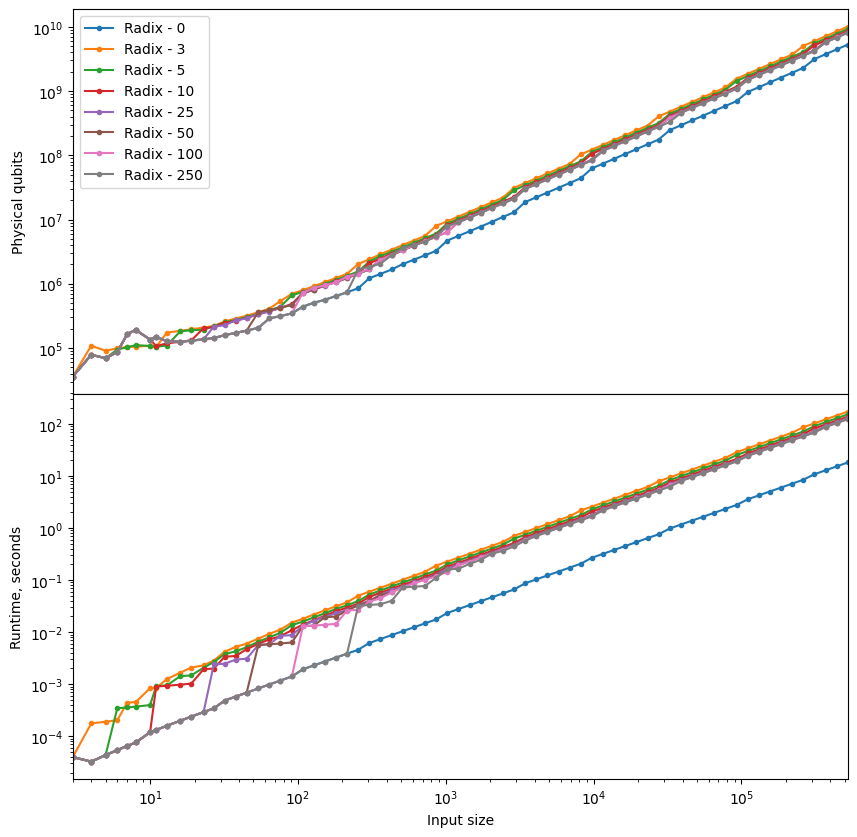

In [3]:
ops_and_max_n_and_c = [
  ("QuantumArithmetic.WBC2023.AddWithOp", 524288), #524288 2**20
]
run_re_experiments(
    ops_and_max_n_and_c,
    estimate_resources_radix
)

### Table of Estimates for Comparison

Here is a table representation of the resources estimes from the experiment above. Again, the radix=0 data is the control, where the adder is called without using higher radix.

In [4]:
show_re_table(
    ops_and_max_n_and_c,
    estimate_resources_radix,
    524288
)

n=524288


,Algorithm,Logical qubits,Physical qubits,Logical depth,"Runtime, seconds"
0,QuantumArithmetic.WBC2023.AddWithOp - 0,3149277,5297517074,1572861,18.245188
1,QuantumArithmetic.WBC2023.AddWithOp - 3,5247403,10085875086,13980443,173.357493
2,QuantumArithmetic.WBC2023.AddWithOp - 5,4827790,9279378900,12372632,153.420637
3,QuantumArithmetic.WBC2023.AddWithOp - 10,4513074,8674494748,11166725,138.467390
4,QuantumArithmetic.WBC2023.AddWithOp - 25,4324262,8311598084,10443134,129.494862
5,QuantumArithmetic.WBC2023.AddWithOp - 50,4261320,8190623560,10201596,126.499790
6,QuantumArithmetic.WBC2023.AddWithOp - 100,4229851,8130140142,10080247,124.995063
7,QuantumArithmetic.WBC2023.AddWithOp - 250,4211380,8094638880,10008792,124.109021


## Adjusting the Radix for Small Set of n

In this experiment the radix size is tested from up to 130. These experiments were performed over addition of n qubits where n was 32, 64, 128, 256, 512, or 1024. This showed that the best radix according to Azure QRE's runtime estimates is when the radix was n/2. It is worth pointing out that when the radix is the same or greater than n, it is equivalent to performing the adder without the higher radix.

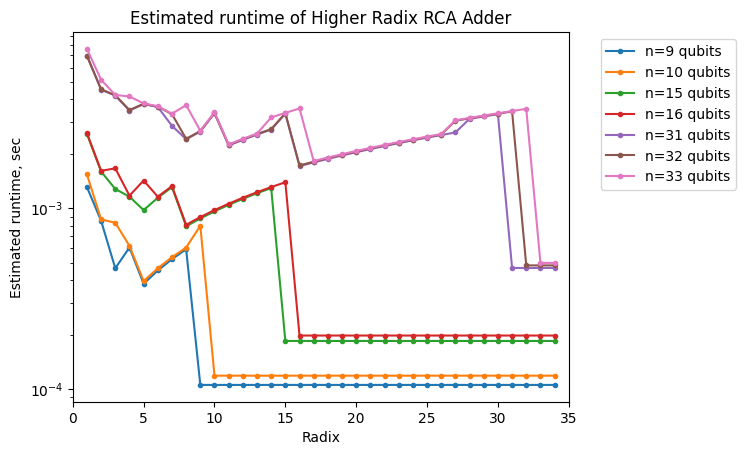

In [5]:
import qsharp
import json
from diskcache import Cache
from matplotlib import pyplot as plt

# radix_range = list(range(1,131))
radix_range = list(range(1,35))

cache2 = Cache("~/quant-arith-cache/re-higher-radix")
@cache2.memoize()
def estimate_resources_radix(n, radix, op, adder_op):
    est = qsharp.estimate(f"EstimateUtils.RunRadix({n},{radix},{op},{adder_op})")
    return json.dumps(est) 

@cache2.memoize()
def estimate_resources_out_of_place_adder(op, n):
    est = qsharp.estimate(f"EstimateUtils.Run3WayOp({n},{n},{n},{op})")
    return json.dumps(est)    

# for n in [32, 64, 128, 256, 512, 1024]:
for n in [9, 10, 15, 16, 31, 32, 33]:
    runtime = []
    for radix in radix_range:
        op = "QuantumArithmetic.CG20192.MultiplyWindow"
        est = json.loads(estimate_resources_radix(n, radix, "QuantumArithmetic.WBC2023.AddWithOp", "Std.Arithmetic.RippleCarryCGAddLE"))
        runtime.append(est['physicalCounts']['runtime']/10**9)
    plt.plot(radix_range, runtime, label=f"n={n} qubits", marker='.')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Radix')
plt.ylabel('Estimated runtime, sec')
plt.title('Estimated runtime of Higher Radix RCA Adder')
plt.xlim([0,35])
plt.yscale('log')
    